# Determine Optimal Experimental Conditions

**Cell Morphology Quantitative Trait Loci (cmQTL) Project**

**Gregory Way, 2019**

We performed a pilot experiment to determine optimal conditions to collect cell painting data.
The conditions included testing `plating density` and `plating time` across 6 different `primary cell lines`.
Each condition and cell line were tested with 16 replicates.

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggridges))
suppressPackageStartupMessages(library(corrplot))

In [2]:
set.seed(123)

In [3]:
# Read in both btches of data
profile_dir <- file.path("..", "..", "..", "backend", "2019_05_13_Batch2")
profile_files <- list.files(profile_dir,
                            recursive = TRUE,
                            full.names = TRUE,
                            pattern = "variable_selected.csv")

profile_cols <- readr::cols(
    .default = readr::col_double(),
    Metadata_Plate = readr::col_character(),
    Metadata_Well = readr::col_character(),
    Metadata_Assay_Plate_Barcode = readr::col_character(),
    Metadata_Plate_Map_Name = readr::col_character(),
    Metadata_well_position = readr::col_character(),
    Metadata_plating_density = readr::col_integer(),
    Metadata_line_ID = readr::col_character(),
    Metadata_timepoint = readr::col_integer()
)


profile_df <- profile_files %>%
    purrr::map(function(x) readr::read_csv(x, col_types = profile_cols)) %>%
    purrr::reduce(rbind)
               
dim(profile_df)
head(profile_df, 2)

[1] 768 597

Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_plating_density,Metadata_line_ID,Metadata_timepoint,Cells_AreaShape_Compactness,Cells_AreaShape_EulerNumber,⋯,Nuclei_Texture_InfoMeas2_Mito_5_00,Nuclei_Texture_InverseDifferenceMoment_DNA_20_03,Nuclei_Texture_SumAverage_Brightfield_20_02,Nuclei_Texture_SumAverage_DNA_20_02,Nuclei_Texture_SumAverage_ER_20_03,Nuclei_Texture_SumEntropy_ER_20_01,Nuclei_Texture_SumVariance_AGP_20_03,Nuclei_Texture_SumVariance_DNA_20_01,Nuclei_Texture_SumVariance_ER_20_03,Nuclei_Texture_SumVariance_Mito_20_01
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BR00103267,A01,BR00103267,cmQTL1-4_mt,A01,5000,A,6,-0.1947785,0.6820607,⋯,1.867574,-0.2956600,2.0677963,-0.7049514,1.402976,3.063689,2.954758,0.2187798,2.9261159,3.340355
BR00103267,A02,BR00103267,cmQTL1-4_mt,A02,5000,A,6,-0.8344320,-2.8679885,⋯,1.163408,0.9157293,0.5817612,-0.9193400,1.817793,1.057007,1.533685,-1.0500258,0.8722195,1.716821


In [4]:
# Separate different cell profiler data
cp_features <- colnames(profile_df) %>%
    stringr::str_subset("^Nuclei_|^Cells_|^Cytoplasm_")

length(cp_features)

cp_metadata <- colnames(profile_df) %>%
    stringr::str_subset("^Metadata_")

length(cp_metadata)

[1] 589

[1] 8

In [5]:
# Create a metadata dictionary and dummy variable "group_id"
# "group_id" distinguishes each separate condition including cell line
# "condition_group_id" distinguishes separate conditions ignoring cell line
metadata_df <- profile_df %>%
    dplyr::select(cp_metadata) %>%
    dplyr::mutate(dictionary_id = paste0("id_", dplyr::row_number()),
                  group_id = group_indices(.,
                                           Metadata_line_ID,
                                           Metadata_plating_density,
                                           Metadata_timepoint,
                                           Metadata_Plate),
                  condition_group_id = group_indices(.,
                                                     Metadata_plating_density,
                                                     Metadata_timepoint,
                                                     Metadata_Plate))

tail(metadata_df)

Metadata_Plate,Metadata_Well,Metadata_Assay_Plate_Barcode,Metadata_Plate_Map_Name,Metadata_well_position,Metadata_plating_density,Metadata_line_ID,Metadata_timepoint,dictionary_id,group_id,condition_group_id
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<int>,<int>
BR00103268,P19,BR00103268,cmQTL5-8_mt,P19,3000,B,24,id_763,11,3
BR00103268,P20,BR00103268,cmQTL5-8_mt,P20,3000,B,24,id_764,11,3
BR00103268,P21,BR00103268,cmQTL5-8_mt,P21,2000,A,24,id_765,2,2
BR00103268,P22,BR00103268,cmQTL5-8_mt,P22,2000,A,24,id_766,2,2
BR00103268,P23,BR00103268,cmQTL5-8_mt,P23,3000,C,24,id_767,19,3
BR00103268,P24,BR00103268,cmQTL5-8_mt,P24,3000,C,24,id_768,19,3


In [6]:
# Create a dataframe of variables for each group
group_id_df <- metadata_df %>%
    dplyr::select(group_id,
                  Metadata_line_ID,
                  Metadata_timepoint,
                  Metadata_plating_density) %>%
    dplyr::distinct() %>%
    dplyr::arrange(group_id)

dim(group_id_df)
head(group_id_df)

[1] 48  4

group_id,Metadata_line_ID,Metadata_timepoint,Metadata_plating_density
<int>,<chr>,<int>,<int>
1,A,24,1000
2,A,24,2000
3,A,24,3000
4,A,24,4000
5,A,6,5000
6,A,6,10000


## How many replicates of each condition?

The different combinations of conditions include:


* Two plates: `BR00103267` and `BR00103268`
* Eight plating densities: `1000`, `2000`, `3000`, `4000`, `5000`, `10000`, `15000`, and `20000`
* Six cell lines: `A`, `B`, `C`, `D`, `E`, `F`
* Two time points: `6` and `24`

There are a total of 48 different combinations.

The distribution of metadata across plates is as follows:

In [7]:
table(profile_df$Metadata_line_ID,
      profile_df$Metadata_plating_density,
      profile_df$Metadata_timepoint,
      profile_df$Metadata_Plate)

, ,  = 6,  = BR00103267

   
    1000 2000 3000 4000 5000 10000 15000 20000
  A    0    0    0    0   16    16    16    16
  B    0    0    0    0   16    16    16    16
  C    0    0    0    0   16    16    16    16
  D    0    0    0    0   16    16    16    16
  E    0    0    0    0   16    16    16    16
  F    0    0    0    0   16    16    16    16

, ,  = 24,  = BR00103267

   
    1000 2000 3000 4000 5000 10000 15000 20000
  A    0    0    0    0    0     0     0     0
  B    0    0    0    0    0     0     0     0
  C    0    0    0    0    0     0     0     0
  D    0    0    0    0    0     0     0     0
  E    0    0    0    0    0     0     0     0
  F    0    0    0    0    0     0     0     0

, ,  = 6,  = BR00103268

   
    1000 2000 3000 4000 5000 10000 15000 20000
  A    0    0    0    0    0     0     0     0
  B    0    0    0    0    0     0     0     0
  C    0    0    0    0    0     0     0     0
  D    0    0    0    0    0     0     0     0
  E    0    0    

## Determine the pairwise correlation across all profiles

In [8]:
cor_melt_df <- metadata_df %>%
    dplyr::select(-group_id,
                  -condition_group_id) %>%
    dplyr::bind_cols(
        profile_df %>%
            dplyr::select(cp_features) %>%
            t() %>%
            cor() %>%
            dplyr::as_tibble() %>%
            magrittr::set_colnames(metadata_df$dictionary_id)
    ) %>%
    dplyr::select(-cp_metadata) %>%
    reshape2::melt(id.vars = 'dictionary_id',
                   variable.name = 'correlation_id', 
                   value.name = "pearson_cor")

dim(cor_melt_df)
head(cor_melt_df)

Warning message:
“`as_tibble.matrix()` requires a matrix with column names or a `.name_repair` argument. Using compatibility `.name_repair`.
This warning is displayed once per session.”

[1] 589824      3

dictionary_id,correlation_id,pearson_cor
<chr>,<fct>,<dbl>
id_1,id_1,1.00000000
id_2,id_1,0.58726506
id_3,id_1,-0.04480419
id_4,id_1,-0.29710191
id_5,id_1,0.59009882
id_6,id_1,0.52417365


In [9]:
# Map group IDs and condition IDs onto the correlation dataframe
# We are interested in correlations between specific groups
cor_group_df <- cor_melt_df %>%
    dplyr::inner_join(
        metadata_df %>%
        select(dictionary_id,
               group_id,
               condition_group_id),
        by = 'dictionary_id'
    ) %>%
    dplyr::rename(pair_a = group_id,
                  pair_a_condition = condition_group_id) %>%
    dplyr::inner_join(
        metadata_df %>%
        select(dictionary_id,
               group_id,
               condition_group_id),
        by = c('correlation_id' = 'dictionary_id')
    ) %>%
    dplyr::rename(pair_b = group_id,
                  pair_a_id = dictionary_id,
                  pair_b_id = correlation_id,
                  pair_b_condition = condition_group_id)

dim(cor_group_df)
head(cor_group_df)

Warning message:
“Column `correlation_id`/`dictionary_id` joining factor and character vector, coercing into character vector”

[1] 589824      7

pair_a_id,pair_b_id,pearson_cor,pair_a,pair_a_condition,pair_b,pair_b_condition
<chr>,<chr>,<dbl>,<int>,<int>,<int>,<int>
id_1,id_1,1.00000000,5,5,5,5
id_2,id_1,0.58726506,5,5,5,5
id_3,id_1,-0.04480419,15,7,5,5
id_4,id_1,-0.29710191,15,7,5,5
id_5,id_1,0.59009882,37,5,5,5
id_6,id_1,0.52417365,37,5,5,5


In [10]:
# Remove self correlations and determine median correlation between all groups
# Also create a variable that represents correlations across cell lines within
# the same condition. This variable will be used as the null distribution.
cor_group_df <- cor_group_df %>%
    dplyr::mutate(
        within_group_cor =
            as.numeric(cor_group_df$pair_a == cor_group_df$pair_b),
        within_group_across_cell_line_cor =
            as.numeric(cor_group_df$pair_a_condition == cor_group_df$pair_b_condition &
                       cor_group_df$pair_a != cor_group_df$pair_b)
    ) %>%
    dplyr::filter(cor_group_df$pair_a_id != cor_group_df$pair_b_id) %>%
    dplyr::group_by(pair_a,
                    pair_b) %>%
    dplyr::mutate(median_cor = median(pearson_cor)) %>%
    dplyr::ungroup() %>%
    dplyr::arrange(desc(median_cor))

dim(cor_group_df)
head(cor_group_df)

[1] 589056     10

pair_a_id,pair_b_id,pearson_cor,pair_a,pair_a_condition,pair_b,pair_b_condition,within_group_cor,within_group_across_cell_line_cor,median_cor
<chr>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
id_64,id_63,0.6362387,48,8,48,8,1,0,0.7659682
id_87,id_63,0.7923264,48,8,48,8,1,0,0.7659682
id_88,id_63,0.8456840,48,8,48,8,1,0,0.7659682
id_101,id_63,0.8483869,48,8,48,8,1,0,0.7659682
id_102,id_63,0.9385151,48,8,48,8,1,0,0.7659682
id_125,id_63,0.7735087,48,8,48,8,1,0,0.7659682


## Generate Plots to Visualize Optimal Conditions

In [11]:
# Join Replicate Correlations and Null Distribution Correlations
within_group_cor_df <- cor_group_df %>%
    dplyr::filter(within_group_cor == 1) %>%
    dplyr::group_by(pair_b) %>%
    dplyr::mutate(pair_b_median_cor = median(pearson_cor),
                  null_data = "Replicate Correlation") %>%
    dplyr::arrange(desc(pair_b_median_cor)) %>%
    dplyr::ungroup()
    

null_group_cor_df <- cor_group_df %>%
    dplyr::filter(within_group_across_cell_line_cor == 1) %>%
    dplyr::group_by(pair_b) %>%
    dplyr::mutate(pair_b_median_cor = median(pearson_cor),
                  null_data = "Matched Cell Lines") %>%
    dplyr::arrange(desc(pair_b_median_cor)) %>%
    dplyr::ungroup()

full_plot_ready <- within_group_cor_df %>%
    dplyr::bind_rows(
        null_group_cor_df
    )

dim(full_plot_ready)
head(full_plot_ready)

[1] 72960    12

pair_a_id,pair_b_id,pearson_cor,pair_a,pair_a_condition,pair_b,pair_b_condition,within_group_cor,within_group_across_cell_line_cor,median_cor,pair_b_median_cor,null_data
<chr>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
id_64,id_63,0.6362387,48,8,48,8,1,0,0.7659682,0.7659682,Replicate Correlation
id_87,id_63,0.7923264,48,8,48,8,1,0,0.7659682,0.7659682,Replicate Correlation
id_88,id_63,0.8456840,48,8,48,8,1,0,0.7659682,0.7659682,Replicate Correlation
id_101,id_63,0.8483869,48,8,48,8,1,0,0.7659682,0.7659682,Replicate Correlation
id_102,id_63,0.9385151,48,8,48,8,1,0,0.7659682,0.7659682,Replicate Correlation
id_125,id_63,0.7735087,48,8,48,8,1,0,0.7659682,0.7659682,Replicate Correlation


In [12]:
# Perform KS tests between real and null distributions
all_results <- list()
for (group_condition in unique(full_plot_ready$pair_b)) {
       full_plot_group_df = full_plot_ready %>%
        dplyr::filter(pair_b == group_condition)

    replicate_corr_df <- full_plot_group_df %>%
        dplyr::filter(within_group_across_cell_line_cor == 0)
    null_corr_df <- full_plot_group_df %>%
        dplyr::filter(within_group_across_cell_line_cor == 1)

    ks_result = ks.test(x = replicate_corr_df$pearson_cor,
                        y = null_corr_df$pearson_cor,
                        alternative = "less")

    k_stat = as.numeric(ks_result$statistic)
    k_p = as.numeric(ks_result$p.value)
    all_results[[group_condition]] <- c(group_condition, k_stat, k_p, -log10(k_p)) 
}

ks_result_df <- dplyr::as_tibble(do.call(rbind, all_results))
colnames(ks_result_df) <- c("group_condition_id", "ks_stat", "ks_p_value", "ks_log_10_p")

ks_result_df <- ks_result_df %>% dplyr::arrange(desc(as.numeric(paste(ks_log_10_p))))

head(ks_result_df)

Warning message in ks.test(x = replicate_corr_df$pearson_cor, y = null_corr_df$pearson_cor, :
“p-value will be approximate in the presence of ties”Warning message in ks.test(x = replicate_corr_df$pearson_cor, y = null_corr_df$pearson_cor, :
“p-value will be approximate in the presence of ties”Warning message in ks.test(x = replicate_corr_df$pearson_cor, y = null_corr_df$pearson_cor, :
“p-value will be approximate in the presence of ties”Warning message in ks.test(x = replicate_corr_df$pearson_cor, y = null_corr_df$pearson_cor, :
“p-value will be approximate in the presence of ties”Warning message in ks.test(x = replicate_corr_df$pearson_cor, y = null_corr_df$pearson_cor, :
“p-value will be approximate in the presence of ties”Warning message in ks.test(x = replicate_corr_df$pearson_cor, y = null_corr_df$pearson_cor, :
“p-value will be approximate in the presence of ties”Warning message in ks.test(x = replicate_corr_df$pearson_cor, y = null_corr_df$pearson_cor, :
“p-value will be approxi

group_condition_id,ks_stat,ks_p_value,ks_log_10_p
<dbl>,<dbl>,<dbl>,<dbl>
40,0.9906250,5.366177e-173,172.2703
45,0.9192708,4.497359e-149,148.3470
30,0.8598958,1.575186e-130,129.8027
37,0.8492188,2.516319e-127,126.5992
39,0.8247396,3.927796e-120,119.4059
46,0.8143229,3.902584e-117,116.4086


In [13]:
# Merge plot ready data with info on group ID
full_plot_ready <- full_plot_ready %>%
    dplyr::left_join(group_id_df, by = c("pair_b" = "group_id"))

# Sort the plot ready dataframe in order of KS significance
full_plot_ready$pair_b <- factor(full_plot_ready$pair_b,
                                 levels = ks_result_df$group_condition_id)

full_plot_ready <- full_plot_ready %>%
    dplyr::mutate(grouped_plot = paste0(Metadata_timepoint,
                                        null_data))

Picking joint bandwidth of 0.0494
Picking joint bandwidth of 0.0533
Picking joint bandwidth of 0.0482
Picking joint bandwidth of 0.0463
Picking joint bandwidth of 0.0553
Picking joint bandwidth of 0.043
Picking joint bandwidth of 0.061
Picking joint bandwidth of 0.0591
Picking joint bandwidth of 0.0575
Picking joint bandwidth of 0.0507
Picking joint bandwidth of 0.0633
Picking joint bandwidth of 0.0672
Picking joint bandwidth of 0.0508
Picking joint bandwidth of 0.0435
Picking joint bandwidth of 0.052
Picking joint bandwidth of 0.0658
Picking joint bandwidth of 0.0473
Picking joint bandwidth of 0.0465
Picking joint bandwidth of 0.0519
Picking joint bandwidth of 0.0521
Picking joint bandwidth of 0.0452
Picking joint bandwidth of 0.0461
Picking joint bandwidth of 0.063
Picking joint bandwidth of 0.0611
Picking joint bandwidth of 0.0476
Picking joint bandwidth of 0.0434
Picking joint bandwidth of 0.0529
Picking joint bandwidth of 0.0504
Picking joint bandwidth of 0.0467
Picking joint band

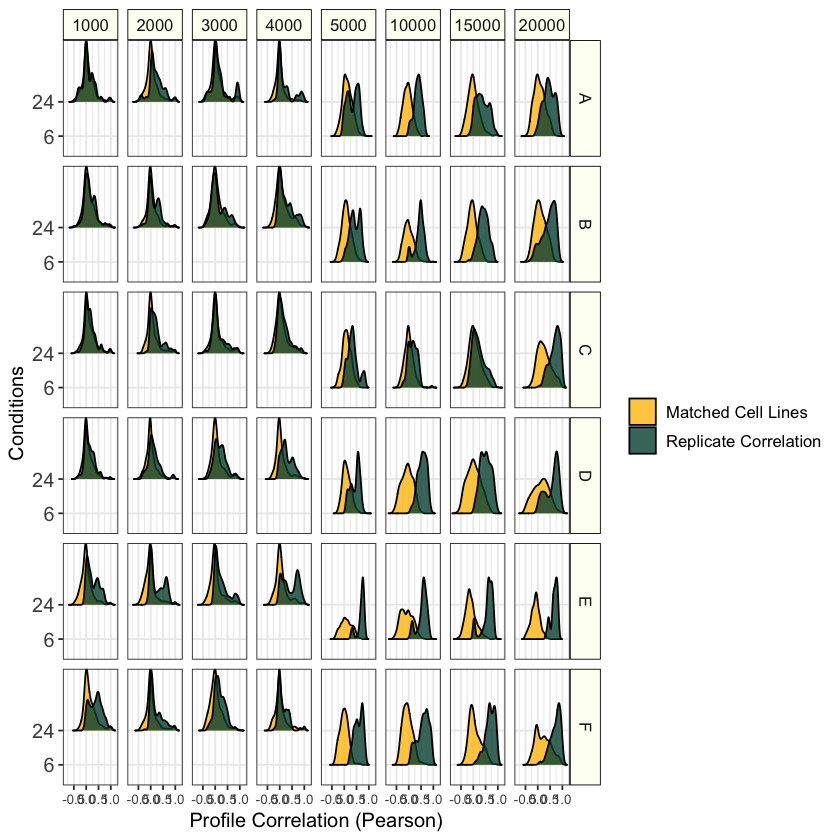

In [14]:
condition_gg <-
    ggplot(full_plot_ready,
           aes(x = pearson_cor,
               y = as.factor(Metadata_timepoint),
               fill = null_data)) +
        geom_density_ridges(alpha = 0.8) +
        ylab("Conditions") +
        xlab("Profile Correlation (Pearson)") +
        theme_bw() +
        facet_grid(Metadata_line_ID~Metadata_plating_density,
                   scales="free_y") +
        scale_fill_manual(name = "",
                          values = c("#FFC107", "#004D40")) +
        theme(axis.text.y = element_text(size = 12),
              axis.text.x = element_text(size = 8),
              axis.title = element_text(size = 12),
              legend.text = element_text(size = 10),
              strip.text = element_text(size = 10),
              strip.background = element_rect(colour = "black",
                                              fill = "#fdfff4"))

condition_gg

In [15]:
file_base <- file.path("figures", "condition_pilot")
for (extension in c('.png', '.pdf')) {
    ggsave(condition_gg,
           filename = paste0(file_base, extension),
           height = 8,
           width = 10)
}

Picking joint bandwidth of 0.0494
Picking joint bandwidth of 0.0533
Picking joint bandwidth of 0.0482
Picking joint bandwidth of 0.0463
Picking joint bandwidth of 0.0553
Picking joint bandwidth of 0.043
Picking joint bandwidth of 0.061
Picking joint bandwidth of 0.0591
Picking joint bandwidth of 0.0575
Picking joint bandwidth of 0.0507
Picking joint bandwidth of 0.0633
Picking joint bandwidth of 0.0672
Picking joint bandwidth of 0.0508
Picking joint bandwidth of 0.0435
Picking joint bandwidth of 0.052
Picking joint bandwidth of 0.0658
Picking joint bandwidth of 0.0473
Picking joint bandwidth of 0.0465
Picking joint bandwidth of 0.0519
Picking joint bandwidth of 0.0521
Picking joint bandwidth of 0.0452
Picking joint bandwidth of 0.0461
Picking joint bandwidth of 0.063
Picking joint bandwidth of 0.0611
Picking joint bandwidth of 0.0476
Picking joint bandwidth of 0.0434
Picking joint bandwidth of 0.0529
Picking joint bandwidth of 0.0504
Picking joint bandwidth of 0.0467
Picking joint band

## Determine Optimal Condition

Warning message:
“Column `pair_b`/`group_condition_id` joining factors with different levels, coercing to character vector”

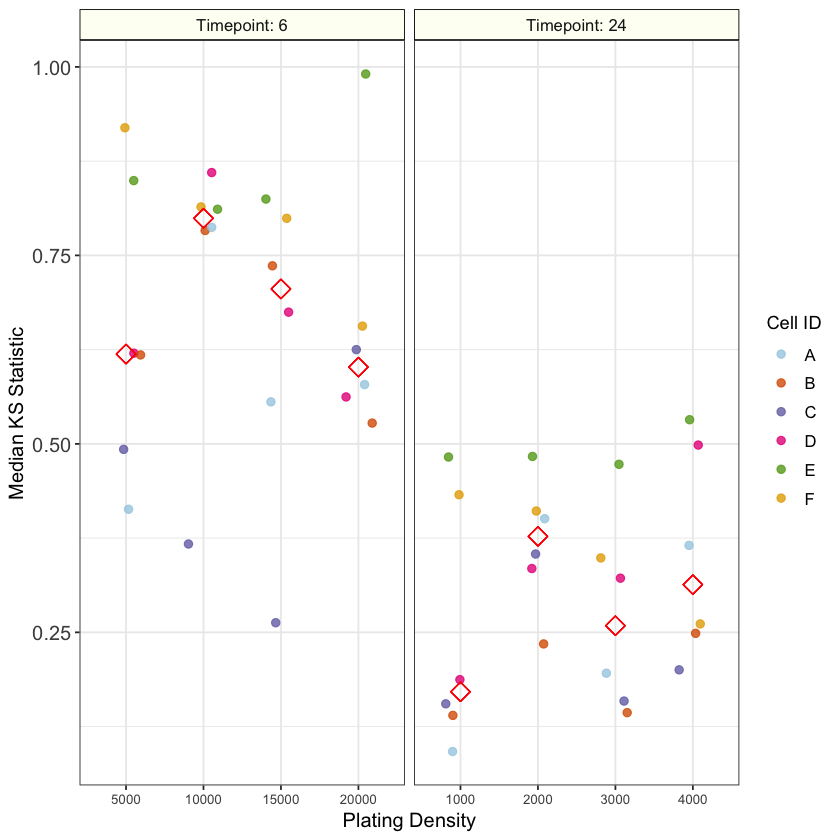

In [16]:
ks_result_df$group_condition_id <- as.factor(ks_result_df$group_condition_id)

final_results_df <- full_plot_ready %>%
    dplyr::left_join(ks_result_df,
                     by = c("pair_b" = "group_condition_id")) %>%
    dplyr::group_by(Metadata_timepoint,
                    Metadata_plating_density,
                    Metadata_line_ID) %>%
    dplyr::mutate(median_cell_ks = median(ks_stat)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(Metadata_timepoint,
                    Metadata_plating_density) %>%
    dplyr::mutate(median_condition_ks = median(ks_stat)) %>%
    dplyr::select(Metadata_timepoint,
                  Metadata_plating_density,
                  Metadata_line_ID,
                  median_cell_ks,
                  median_condition_ks) %>%
    dplyr::distinct() %>%
    dplyr::ungroup()


append_timepoint <- function(string) paste("Timepoint:", string)

ks_test_gg <- ggplot(final_results_df) +
    geom_jitter(aes(y = median_cell_ks,
                    x = as.factor(Metadata_plating_density),
                    color = Metadata_line_ID),
                size = 2,
                height = 0,
                width = 0.2,
                alpha = 0.8) +
    geom_point(aes(y = median_condition_ks,
                   x = as.factor(Metadata_plating_density)),
               color = "red",
               shape = 23,
               size = 4) +
    scale_color_manual(name = "Cell ID",
                       values = c("#a6cee3",
                                  "#d95f02",
                                  "#7570b3",
                                  "#e7298a",
                                  "#66a61e",
                                  "#e6ab02")) +
    facet_grid(~Metadata_timepoint,
               scales = "free_x",
               labeller = labeller(Metadata_timepoint = as_labeller(append_timepoint))) +
    xlab("Plating Density") +
    ylab("Median KS Statistic") +
    theme_bw() +
    theme(axis.text.y = element_text(size = 12),
          axis.text.x = element_text(size = 8),
          axis.title = element_text(size = 12),
          legend.text = element_text(size = 10),
          strip.text = element_text(size = 10),
          strip.background = element_rect(colour = "black",
                                          fill = "#fdfff4"))

ks_test_gg

In [17]:
file_base <- file.path("figures", "condition_pilot_kstest")
for (extension in c('.png', '.pdf')) {
    ggsave(ks_test_gg,
           filename = paste0(file_base, extension),
           height = 5,
           width = 6)
}

## Generate a summary table of KS Test Results

In [18]:
final_results_df <- full_plot_ready %>%
    dplyr::left_join(ks_result_df,
                     by = c("pair_b" = "group_condition_id")) %>%
    dplyr::group_by(Metadata_timepoint,
                    Metadata_plating_density) %>%
    dplyr::mutate(median_ks = median(ks_stat),
                  low_ks = min(ks_stat),
                  high_ks = max(ks_stat)) %>%
    dplyr::select(Metadata_timepoint,
                  Metadata_plating_density,
                  median_ks,
                  low_ks,
                  high_ks) %>%
    dplyr::distinct() %>%
    dplyr::ungroup() %>%
    dplyr::arrange(desc(median_ks))

file <- file.path("results", "pilot_condition_results.tsv")
readr::write_tsv(final_results_df, file)

final_results_df

Warning message:
“Column `pair_b`/`group_condition_id` joining factors with different levels, coercing to character vector”

Metadata_timepoint,Metadata_plating_density,median_ks,low_ks,high_ks
<int>,<int>,<dbl>,<dbl>,<dbl>
6,10000,0.7992188,0.36718750,0.8598958
6,15000,0.7054688,0.26276042,0.8247396
6,5000,0.6191406,0.41328125,0.9192708
6,20000,0.6018229,0.52760417,0.9906250
24,2000,0.3773438,0.23463542,0.4833333
24,4000,0.3132813,0.20026042,0.5320313
24,3000,0.2588542,0.14348958,0.4729167
24,1000,0.1712240,0.09192708,0.4825521
